### RAG with MongoDB- Data Integration , Retrieval And Generation Pipeline

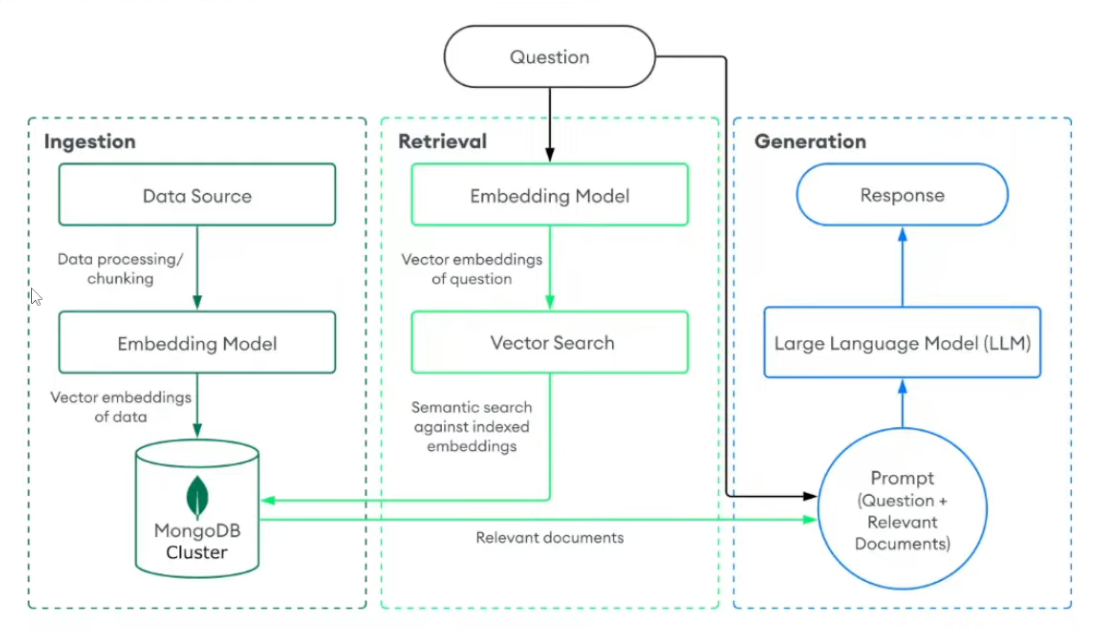

In [20]:
import chunk

from IPython.display import display, HTML

display(HTML("""
<style>
.output_area pre {
    white-space: pre !important;
}
</style>
"""))

In [21]:
# Data Ingestion
import os
from dotenv import load_dotenv

load_dotenv()
mongo_uri = os.getenv("MONGO_DB_CONNECTION_STRING")
openai_api_key = os.environ["OPENAI_API_KEY"]

In [22]:
from openai import OpenAI

# initialize the client
client = OpenAI(api_key=openai_api_key)

# Specify the embedding model
model = "text-embedding-3-large"

# define the function to generate the embedding
def get_embedding(text, input_type='document'):
    response = client.embeddings.create(input=text, model=model)
    return response.data[0].embedding


In [23]:
get_embedding("RAG technology")

[-0.05236838757991791,
 -0.036115508526563644,
 -0.0292731374502182,
 -0.003553633112460375,
 -0.04680110141634941,
 0.020652826875448227,
 -0.028357230126857758,
 0.03105107694864273,
 0.0024311968591064215,
 0.04813006520271301,
 0.042742371559143066,
 -0.03212861716747284,
 0.04428684338927269,
 -0.022915659472346306,
 -0.028949875384569168,
 0.03947383910417557,
 -0.018039794638752937,
 -0.006833391729742289,
 0.011790070682764053,
 -0.0023077288642525673,
 0.024747474119067192,
 -0.014196573756635189,
 -0.01912631466984749,
 0.011646398343145847,
 -0.011996598914265633,
 -0.0071521638892591,
 -0.014735342934727669,
 0.011269260197877884,
 -0.0742783397436142,
 -0.0035132255870848894,
 0.06260500848293304,
 0.03965342789888382,
 0.0017049807356670499,
 0.000771113729570061,
 -0.00967091042548418,
 -0.010434167459607124,
 0.012679040431976318,
 0.021443022415041924,
 0.007250938098877668,
 -0.02641765959560871,
 0.021029965952038765,
 -0.006909717805683613,
 -0.030260881409049034,
 

In [24]:
embed = get_embedding("RAG technology")
print(len(embed))

3072


In [25]:
# Data Ingestion
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# load the pdf
loader = PyPDFLoader("https://investors.mongodb.com/node/12236/pdf")
data = loader.load()

# split the data
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(data)


In [26]:
print(chunks)

[Document(metadata={'producer': 'West Corporation using ABCpdf', 'creator': 'PyPDF', 'creationdate': '2024-05-30T20:06:12+00:00', 'title': 'MongoDB, Inc. Announces First Quarter Fiscal 2025 Financial Results', 'source': 'https://investors.mongodb.com/node/12236/pdf', 'total_pages': 8, 'page': 0, 'page_label': '1'}, page_content='MongoDB, Inc. Announces First Quarter Fiscal 2025 Financial Results\nMay 30, 2024\nFirst Quarter Fiscal 2025 Total Revenue of $450.6 million, up 22% Year-over-Year\nContinued Strong Customer Growth with Over 49,200 Customers as of April 30, 2024\nMongoDB Atlas Revenue up 32% Year-over-Year; 70% of Total Q1 Revenue\xa0\nNEW YORK , May 30, 2024 /PRNewswire/ -- MongoDB, Inc. (NASDAQ: MDB) today announced its financial results for the first quarter ended April 30,\n2024.\n\xa0\n  \xa0\n"MongoDB\'s delivered solid first quarter results, highlighted by 32% Atlas revenue growth. At the same time, we had a slower than expected start to\nthe year for both Atlas consumpt

In [27]:
# prepare documents for insertion
chunks_to_insert = [{
    "text": chunk.page_content,
    "embedding": get_embedding(chunk.page_content)
} for chunk in chunks]

In [10]:
len(chunks_to_insert)

39

In [9]:
# insert the data into the mongoDB cluster
from pymongo import MongoClient

# connect to mongodb deployment
client = MongoClient(mongo_uri)
collection = client['sample_mflix']['rag_pdf']

#insert chunks into the collection above
result = collection.insert_many(chunks_to_insert)
print(result.inserted_ids)

[ObjectId('69506d04c17e3d54bf8176b5'), ObjectId('69506d04c17e3d54bf8176b6'), ObjectId('69506d04c17e3d54bf8176b7'), ObjectId('69506d04c17e3d54bf8176b8'), ObjectId('69506d04c17e3d54bf8176b9'), ObjectId('69506d04c17e3d54bf8176ba'), ObjectId('69506d04c17e3d54bf8176bb'), ObjectId('69506d04c17e3d54bf8176bc'), ObjectId('69506d04c17e3d54bf8176bd'), ObjectId('69506d04c17e3d54bf8176be'), ObjectId('69506d04c17e3d54bf8176bf'), ObjectId('69506d04c17e3d54bf8176c0'), ObjectId('69506d04c17e3d54bf8176c1'), ObjectId('69506d04c17e3d54bf8176c2'), ObjectId('69506d04c17e3d54bf8176c3'), ObjectId('69506d04c17e3d54bf8176c4'), ObjectId('69506d04c17e3d54bf8176c5'), ObjectId('69506d04c17e3d54bf8176c6'), ObjectId('69506d04c17e3d54bf8176c7'), ObjectId('69506d04c17e3d54bf8176c8'), ObjectId('69506d04c17e3d54bf8176c9'), ObjectId('69506d04c17e3d54bf8176ca'), ObjectId('69506d04c17e3d54bf8176cb'), ObjectId('69506d04c17e3d54bf8176cc'), ObjectId('69506d04c17e3d54bf8176cd'), ObjectId('69506d04c17e3d54bf8176ce'), ObjectId('6

In [11]:
### query with search index
from pymongo.operations import SearchIndexModel
import time

# Create your index model, then create the search index
index_name="vector_index"
search_index_model = SearchIndexModel(
  definition = {
    "fields": [
      {
        "type": "vector",
        "numDimensions": 3072,
        "path": "embedding",
        "similarity": "cosine"
      }
    ]
  },
  name = index_name,
  type = "vectorSearch"
)

collection.create_search_index(model=search_index_model)

'vector_index'

In [28]:
# Wait for initial sync to complete
print("Polling to check if the index is ready. This may take up to a minute.")
predicate=None
if predicate is None:
   predicate = lambda index: index.get("queryable") is True

while True:
   indices = list(collection.list_search_indexes(index_name))
   if len(indices) and predicate(indices[0]):
      break
   time.sleep(5)
print(index_name + " is ready for querying.")

Polling to check if the index is ready. This may take up to a minute.
vector_index is ready for querying.


In [29]:
query_embedding = get_embedding("AI Technology")

In [31]:
results = collection.rag_pdf.aggregate([
  {
    "$vectorSearch": {
      "index": "vector_index",
      "path": "embedding",
      "queryVector":query_embedding,
      "numCandidates":3072 ,
      "limit": 5
    }
  }
])

In [33]:
for doc in results:
    print(doc)

In [34]:
results

In [35]:
# Define a function to run vector search queries
def get_query_results(query):
  """Gets results from a vector search query."""

  query_embedding = get_embedding(query, input_type="query")
  print(query_embedding)
  pipeline = [
      {
            "$vectorSearch": {
              "index": "vector_index",
              "queryVector": query_embedding,
              "path": "embedding",
              "numCandidates":3072,
              "limit": 5
            }
      }, {
            "$project": {
              "_id": 0,
              "text": 1
         }
      }
  ]

  results = collection.aggregate(pipeline)
  print(results)

  array_of_results = []
  for doc in results:
      array_of_results.append(doc)
  return array_of_results


In [36]:
# Test the function with a sample query
get_query_results("mongodb vector search")

[-0.014096962288022041, 0.010744848288595676, -0.0008071675547398627, 0.04186665639281273, -0.0025592907331883907, 0.005852290894836187, -0.004454417619854212, 0.05046253651380539, -0.054690927267074585, 0.04047573730349541, 0.019445044919848442, 0.006599909625947475, -0.025286903604865074, -0.008693242445588112, -0.0015021923463791609, 0.03805553913116455, -0.013165046460926533, 0.0015717382775619626, -0.023645620793104172, -0.012372222729027271, -0.028235651552677155, 0.008922744542360306, 0.011669808998703957, 0.032686591148376465, -0.03560752049088478, 0.002340220846235752, -0.0044161672703921795, -0.0005837512435391545, -0.003136521903797984, -0.001556090428493917, -0.01776203326880932, 0.01934768073260784, -0.001285730628296733, 0.003209545277059078, 0.0009649499552324414, -0.002020309679210186, 0.0006511238752864301, -0.03505115583539009, -0.015981657430529594, -0.029431842267513275, 0.0008445485145784914, 0.00870019756257534, -0.03936300426721573, 0.0015187094686552882, 0.00383

[{'text': "that allow development teams to address the growing requirements for today's wide variety of modern applications, all in a unified and consistent user\nexperience. MongoDB  has tens of thousands of customers in over 100 countries. The MongoDB  database platform has been downloaded hundreds of\nmillions of times since 2007, and there have been millions of builders trained through MongoDB University courses. To learn more, visit\xa0mongodb.com .\nInvestor Relations\nBrian Denyeau\nICR for MongoDB\n646-277-1251\nir@mongodb.com\xa0\nMedia Relations\nMongoDB\npress@mongodb.com \xa0\nMONGODB, INC. \xa0\nCONDENSED CONSOLIDATED BALANCE SHEETS\n(in thousands, except share and per share data)\n(unaudited)\nApril 30, 2024January 31, 2024\nAssets\nCurrent assets:\nCash and cash equivalents\xa0\xa0 $\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 815,704$\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 802,959\nShort-term investments 1,258,292 1,212,448\nAccounts receivable, net of allowance for doubtf

In [37]:
from openai import OpenAI

# Specify search query, retrieve relevant documents, and convert to string
query = "What are MongoDB's latest AI announcements?"
context_docs = get_query_results(query)
context_string = " ".join([doc["text"] for doc in context_docs])

# Construct prompt for the LLM using the retrieved documents as the context
prompt = f"""Use the following pieces of context to answer the question at the end.
    {context_string}
    Question: {query}
"""

openai_client = OpenAI()

# OpenAI model to use
model_name = "gpt-4o"

completion = openai_client.chat.completions.create(
model=model_name,
messages=[{"role": "user",
    "content": prompt
  }]
)
print(completion.choices[0].message.content)

[-0.013731470331549644, 0.005906258709728718, -0.0228282380849123, 0.047860946506261826, 0.0026227906346321106, -0.015391464345157146, -0.009269406087696552, 0.019162971526384354, 0.014594667591154575, 0.059653542935848236, 0.04788750782608986, -0.024899909272789955, 0.016254661604762077, 0.020398005843162537, -0.010630602017045021, -0.013419391587376595, -0.01851225271821022, -0.002805389929562807, 0.02118152379989624, -0.037316665053367615, -0.024448391050100327, -0.01025876309722662, 0.021208083257079124, 0.027250461280345917, -0.04467375949025154, 0.0014342347858473659, 0.010969240218400955, -0.01335299201309681, -0.018299773335456848, -0.014275948517024517, -0.007881651632487774, -0.019070010632276535, 0.036254268139600754, -0.026559904217720032, -0.02580294758081436, -0.009136606939136982, 0.024289032444357872, -0.0023820914793759584, 0.02950805425643921, -0.011022360064089298, 0.010803241282701492, 0.017556097358465195, -0.010617321357131004, 0.009501805528998375, -0.02236343920